# Feature Extraction

In this notebook feature extration methods will be implemented and various datasets will be saved.

For the implementation details and the results please refer to [project report](./README.md).

In [1]:
# Import dependencies
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pickle
import os

%matplotlib inline

## HOG Features

A function will be defined to extract HOG features.

In [2]:
# define a function to get hog feature
def get_hog(img, pix_per_cell=(8,8),
    cell_per_block=(2,2), orient=9,
    output_img=False):
    """Get HOG feature as flat array.
    
    Returns features as flattened array and the hog image.
    
    Args:
        pix_per_cell(tuple): 2-tuple, specifies the cell size over which each 
            gradient histogram is computed.
        cells_per_block(tuple): 2-tuple, specifies the local area over which 
            the histogram counts in a given cell will be normalized. 
        orient(int): Represents the number of orientation bins.
        output_img(bool): If `False` hog image will not be returned.
    """
    
    if output_img:
        features, hog_image = hog(
            img, orientations=orient, 
            pixels_per_cell=pix_per_cell, cells_per_block=cell_per_block,
            visualise=True, feature_vector=True, block_norm='L2-Hys')
        
        return features, hog_image
    else:
        features = hog(
            img, orientations=orient, 
            pixels_per_cell=pix_per_cell, cells_per_block=cell_per_block,
            visualise=False, feature_vector=True, block_norm='L2-Hys')
        
        return features

Explore the hog features of a car from the test images. Grayscale the image first.

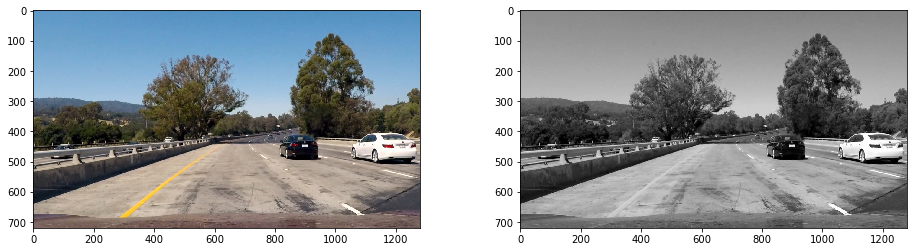

In [3]:
# read test1 image and convert to gray
test1 = mpimg.imread('./test_images/test1.jpg')
gray = cv2.cvtColor(test1, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.imshow(test1)
plt.subplot(122)
plt.imshow(gray, cmap='gray')
plt.show()
plt.close()

Cropout and investigate the car for hog features with various pixel numbers in cells.

The feature number of 2x2 cell size: 139356
The feature number of 8x8 cell size: 7524
The feature number of 16x16 cell size: 1620


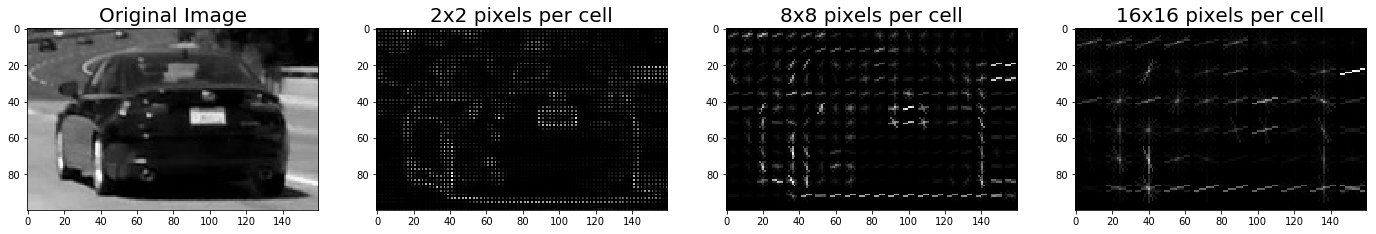

In [4]:
car = gray[400:500,800:960]

pix_per_cell_list = [
    (2, 2),
    (8, 8),
    (16, 16)
]

plt.figure(figsize=(24,8))
plt.subplot(1,4,1)
plt.imshow(car, cmap='gray')
plt.title('Original Image', fontsize=20)
i = 2
for pix_per_cell in pix_per_cell_list:
    features, hog_img = get_hog(car, pix_per_cell=pix_per_cell, output_img=True)
    print('The feature number of ' + str(pix_per_cell[0]) 
        + 'x' + str(pix_per_cell[1]) + ' cell size: '
        + str(features.shape[0]))
    plt.subplot(1,4,i)
    plt.imshow(hog_img, cmap='gray')
    plt.title(
        str(pix_per_cell[0]) + 'x' 
        + str(pix_per_cell[1]) + ' pixels per cell',
        fontsize=20)
    i += 1
plt.show()
plt.close()

Explore HOG features in H channel of HSV space.

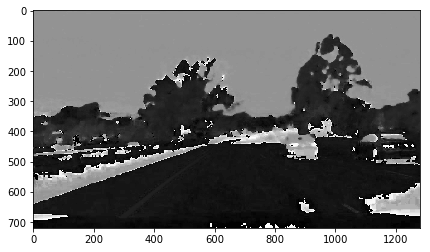

The feature number of 2x2 cell size: 139356
The feature number of 8x8 cell size: 7524
The feature number of 16x16 cell size: 1620


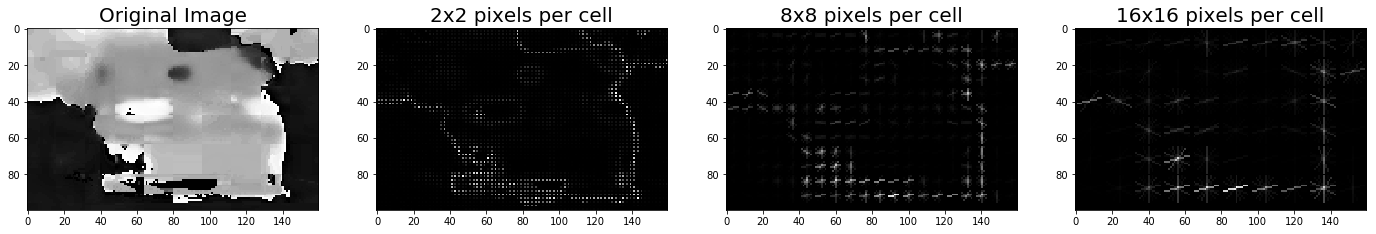

In [6]:
# test on h channel
test1_hsv = cv2.cvtColor(test1, cv2.COLOR_RGB2HSV)
test1_h = test1_hsv[:,:,0]

plt.figure(figsize=(12,4))
plt.imshow(test1_h, cmap='gray')
plt.show()
plt.close()

car = test1_h[400:500,800:960]

pix_per_cell_list = [
    (2, 2),
    (8, 8),
    (16, 16)
]

plt.figure(figsize=(24,8))
plt.subplot(1,4,1)
plt.imshow(car, cmap='gray')
plt.title('Original Image', fontsize=20)
i = 2
for pix_per_cell in pix_per_cell_list:
    features, hog_img = get_hog(car, pix_per_cell=pix_per_cell, output_img=True)
    print('The feature number of ' + str(pix_per_cell[0]) 
        + 'x' + str(pix_per_cell[1]) + ' cell size: '
        + str(features.shape[0]))
    plt.subplot(1,4,i)
    plt.imshow(hog_img, cmap='gray')
    plt.title(
        str(pix_per_cell[0]) + 'x' 
        + str(pix_per_cell[1]) + ' pixels per cell',
        fontsize=20)
    i += 1
plt.show()
plt.close()

## Prepare The Dataset

HOG features will be extracted from different color spaces and the datasets with these features will be saved for accuracy investigation.

In [4]:
import glob
import seaborn as sns

### Dataset helper functions

In [5]:
def get_dataset(
    img_groups, label_groups,
    pix_per_cell=(8,8), cell_per_block=(1,1),
    channel='gray', hist_eq=False):
    """Using images and labels form the dataset.
    
    Outputs the dataset of numpy array features and labels.
    
    Args:
        img_groups: List of image groups, like a list of
            vehicle images paths and non-vehicle images paths.
        label_groups: List of label groups.
        channel: Color space to get hog features. Can be
            `gray`, `rgb`, `hsv` or for the combined `rgbhsv`.
    """
    def convert2uin8(img):
        return np.uint8(255 * img / np.max(img))
    feature_list = []
    labels = []
    for paths, label in zip(img_groups, label_groups):
        for i,path in enumerate(paths):
            if i%3000 == 0:
                print('step ' + str(i) + ' is passed for label ' + str(label))
            img = mpimg.imread(path)
            if img.dtype != np.dtype(np.uint8):
                img = convert2uin8(img)
            if channel == 'gray':
                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                if hist_eq:
                    gray = cv2.equalizeHist(gray)
                features = get_hog(
                    gray, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                feature_list.append(features)
            elif channel == 'rgb':
                ch1 = img[:,:,0]
                ch2 = img[:,:,1]
                ch3 = img[:,:,2]
                if hist_eq:
                    ch1 = cv2.equalizeHist(ch1)
                    ch2 = cv2.equalizeHist(ch2)
                    ch3 = cv2.equalizeHist(ch3)
                features1 = get_hog(
                    ch1, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                features2 = get_hog(
                    ch2, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                features3 = get_hog(
                    ch3, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                features = []
                features.extend(features1)
                features.extend(features2)
                features.extend(features3)
                feature_list.append(features)
            elif channel == 'hsv':
                hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
                ch1 = hsv[:,:,0]
                ch2 = hsv[:,:,1]
                ch3 = hsv[:,:,2]
                if hist_eq:
                    ch1 = cv2.equalizeHist(ch1)
                    ch2 = cv2.equalizeHist(ch2)
                    ch3 = cv2.equalizeHist(ch3)
                features1 = get_hog(
                    ch1, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                features2 = get_hog(
                    ch2, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                features3 = get_hog(
                    ch3, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                features = []
                features.extend(features1)
                features.extend(features2)
                features.extend(features3)
                feature_list.append(features)
            elif channel == 'rgbhsv':
                hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
                ch1 = img[:,:,0]
                ch2 = img[:,:,1]
                ch3 = img[:,:,2]
                ch4 = hsv[:,:,0]
                ch5 = hsv[:,:,1]
                ch6 = hsv[:,:,2]
                if hist_eq:
                    ch1 = cv2.equalizeHist(ch1)
                    ch2 = cv2.equalizeHist(ch2)
                    ch3 = cv2.equalizeHist(ch3)
                    ch4 = cv2.equalizeHist(ch4)
                    ch5 = cv2.equalizeHist(ch5)
                    ch6 = cv2.equalizeHist(ch6)
                features1 = get_hog(
                    ch1, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                features2 = get_hog(
                    ch2, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                features3 = get_hog(
                    ch3, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False),
                features4 = get_hog(
                    ch4, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                features5 = get_hog(
                    ch5, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                features6 = get_hog(
                    ch6, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block, output_img=False)
                features = []
                features.extend(features1)
                features.extend(features2)
                features.extend(features3)
                features.extend(features4)
                features.extend(features5)
                features.extend(features6)
                feature_list.append(features)
            labels.append(label)
    X = np.array(feature_list, dtype=np.float64)
    y = np.array(labels, dtype=np.float64)
    
    # randomize
    np.random.seed(42)
    #print(X.shape)
    order = np.random.permutation(X.shape[0])
    X = X[order]
    y = y[order]
    
    return X, y

### Get image paths

In [6]:
# get vehicle images
vehicles_gti_far = glob.glob('./vehicle-detection-data/vehicles/GTI_Far/*.png')
vehicles_gti_left = glob.glob('./vehicle-detection-data/vehicles/GTI_Left/*.png')
vehicles_gti_right = glob.glob('./vehicle-detection-data/vehicles/GTI_Right/*.png')
vehicles_gti_mid = glob.glob('./vehicle-detection-data/vehicles/GTI_MiddleClose/*.png')
vehicles_kitti = glob.glob('./vehicle-detection-data/vehicles/KITTI_extracted/*.png')

# get non-vehicles
non_vehicles_gti = glob.glob('./vehicle-detection-data/non-vehicles/GTI/*.png')
non_vehicles_extras = glob.glob('./vehicle-detection-data/non-vehicles/Extras/*.png')

In [7]:
# prepare groups
vehicle_paths = (
        vehicles_gti_far
        + vehicles_gti_left
        + vehicles_gti_right
        + vehicles_gti_mid
        + vehicles_kitti
    )

non_vehicle_paths = (
        non_vehicles_gti
        + non_vehicles_extras
    )

img_groups = [vehicle_paths, non_vehicle_paths]
img_groups_tiny = [vehicle_paths[0:2000], non_vehicle_paths[0:2000]]
label_groups = [1, 0] # 1 for vehicles and 0 for non-vehicles

### Create small datasets for feature exploration

Datasets with small sizes (2000 vehicle examples and 2000 non-vehicle examples) will be saved for a quick model and accuracy exploration.

In [28]:
# get tiny datasets
#pix_per_cell_list = [(8,8), (16,16)]
#cell_per_block_list = [(1,1), (2,2)]
hist_eq_list = [True, False]
#color_space_list = ['gray', 'rgb', 'hsv']

pix_per_cell_list = [(16,16)]
cell_per_block_list = [(3,3), (4,4)]
color_space_list = ['gray', 'rgb']

for color_space in color_space_list:
    for pix_per_cell in pix_per_cell_list:
        for cell_per_block in cell_per_block_list:
            for hist_eq in hist_eq_list:

                X, y = get_dataset(
                    img_groups_tiny, label_groups,
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                    channel=color_space, hist_eq=hist_eq)

                # picle the dataset
                path = './datasets/' + color_space + '-tiny'
                if not os.path.exists(path):
                    os.makedirs(path)

                dataset = {}
                dataset['features'] = X
                dataset['labels'] = y

                with open(
                    path
                    + '/dataset-pix-'
                    + str(pix_per_cell[0])
                    + '-'
                    + str(pix_per_cell[1])
                    + '-cell-'
                    + str(cell_per_block[0])
                    + '-'
                    + str(cell_per_block[1])
                    + '-histeq-'
                    + str(1 if hist_eq else 0)
                    + '.pkl', mode='wb') as f:
                    pickle.dump(dataset, f)
    
                print(
                    str(color_space)
                    + str(pix_per_cell)
                    + str(cell_per_block)
                    + str(hist_eq)
                    + ' is done')
                print(X.shape)

step 0 is passed for label 1
step 0 is passed for label 0
(4000, 324)
gray(16, 16)(3, 3)True is done
(4000, 324)
step 0 is passed for label 1
step 0 is passed for label 0
(4000, 324)
gray(16, 16)(3, 3)False is done
(4000, 324)
step 0 is passed for label 1
step 0 is passed for label 0
(4000, 144)
gray(16, 16)(4, 4)True is done
(4000, 144)
step 0 is passed for label 1
step 0 is passed for label 0
(4000, 144)
gray(16, 16)(4, 4)False is done
(4000, 144)
step 0 is passed for label 1
step 0 is passed for label 0
(4000, 972)
rgb(16, 16)(3, 3)True is done
(4000, 972)
step 0 is passed for label 1
step 0 is passed for label 0
(4000, 972)
rgb(16, 16)(3, 3)False is done
(4000, 972)
step 0 is passed for label 1
step 0 is passed for label 0
(4000, 432)
rgb(16, 16)(4, 4)True is done
(4000, 432)
step 0 is passed for label 1
step 0 is passed for label 0
(4000, 432)
rgb(16, 16)(4, 4)False is done
(4000, 432)


### Save a best dataset with RGB space features

After the [exploration](./feature-exploration.ipynb) with small datasets, save the top datasets including all of the examples for a final training.

In [12]:
# save best dataset with rgb features

path = './datasets/rgb'
pix_per_cell = (16, 16)
cell_per_block = (2, 2)
hist_eqs = [True, False]
color_space = 'rgb'

if not os.path.exists(path):
    os.makedirs(path)

for hist_eq in hist_eqs:
    # get whole datasets
    X, y = get_dataset(
        img_groups, label_groups,
        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
        channel=color_space, hist_eq=hist_eq)

    dataset = {}
    dataset['features'] = X
    dataset['labels'] = y
    
    with open(
        path
        + '/dataset-pix-'
        + str(pix_per_cell[0])
        + '-'
        + str(pix_per_cell[1])
        + '-cell-'
        + str(cell_per_block[0])
        + '-'
        + str(cell_per_block[1])
        + '-histeq-'
        + str(1 if hist_eq else 0)
        + '.pkl', mode='wb') as f:
        pickle.dump(dataset, f)

    print(X.shape)
    print(y.shape)

step 0 is passed for label 1
step 3000 is passed for label 1
step 6000 is passed for label 1
step 0 is passed for label 0
step 3000 is passed for label 0
step 6000 is passed for label 0
(17760, 972)
(17760,)
step 0 is passed for label 1
step 3000 is passed for label 1
step 6000 is passed for label 1
step 0 is passed for label 0
step 3000 is passed for label 0
step 6000 is passed for label 0
(17760, 972)
(17760,)


### Save a best dataset with GRAY features

In [13]:
# save best dataset with gray features

path = './datasets/gray'
pix_per_cell = (16, 16)
cell_per_block = (2, 2)
hist_eqs = [True, False]
color_space = 'gray'

if not os.path.exists(path):
    os.makedirs(path)

for hist_eq in hist_eqs:
    # get whole datasets
    X, y = get_dataset(
        img_groups, label_groups,
        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
        channel=color_space, hist_eq=hist_eq)

    dataset = {}
    dataset['features'] = X
    dataset['labels'] = y
    
    with open(
        path
        + '/dataset-pix-'
        + str(pix_per_cell[0])
        + '-'
        + str(pix_per_cell[1])
        + '-cell-'
        + str(cell_per_block[0])
        + '-'
        + str(cell_per_block[1])
        + '-histeq-'
        + str(1 if hist_eq else 0)
        + '.pkl', mode='wb') as f:
        pickle.dump(dataset, f)

    print(X.shape)
    print(y.shape)

step 0 is passed for label 1
step 3000 is passed for label 1
step 6000 is passed for label 1
step 0 is passed for label 0
step 3000 is passed for label 0
step 6000 is passed for label 0
(17760, 324)
(17760,)
step 0 is passed for label 1
step 3000 is passed for label 1
step 6000 is passed for label 1
step 0 is passed for label 0
step 3000 is passed for label 0
step 6000 is passed for label 0
(17760, 324)
(17760,)


### Augment and save the best dataset with false positives (RGB space features)

In [11]:
non_vehicles_false_positives = glob.glob(
    './vehicle-detection-data/non-vehicles/false-positives/*.png')

non_vehicle_paths_augmented = (
        non_vehicles_gti
        + non_vehicles_extras
        + non_vehicles_false_positives
    )

img_groups_augmented = [vehicle_paths, non_vehicle_paths_augmented]

In [36]:
# save best dataset which is augmented with false positive examples (RGB space only)

path = './datasets/rgb-augmented-false-positives'
pix_per_cell = (16, 16)
cell_per_block = (2, 2)
hist_eqs = [True]
color_space = 'rgb'

if not os.path.exists(path):
    os.makedirs(path)

for hist_eq in hist_eqs:
    # get whole datasets
    X, y = get_dataset(
        img_groups_augmented, label_groups,
        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
        channel=color_space, hist_eq=hist_eq)

    dataset = {}
    dataset['features'] = X
    dataset['labels'] = y
    
    with open(
        path
        + '/dataset-pix-'
        + str(pix_per_cell[0])
        + '-'
        + str(pix_per_cell[1])
        + '-cell-'
        + str(cell_per_block[0])
        + '-'
        + str(cell_per_block[1])
        + '-histeq-'
        + str(1 if hist_eq else 0)
        + '.pkl', mode='wb') as f:
        pickle.dump(dataset, f)

    print(X.shape)
    print(y.shape)

step 0 is passed for label 1
step 3000 is passed for label 1
step 6000 is passed for label 1
step 0 is passed for label 0
step 3000 is passed for label 0
step 6000 is passed for label 0
step 9000 is passed for label 0
(17863, 972)
(17863,)


### Extra augment and save the best dataset with false positives (RGB space features)

In [11]:
non_vehicles_augmented_false_positives = glob.glob(
    './vehicle-detection-data/non-vehicles/false-positives-augmented/*.png')

non_vehicle_paths_extra_augmented = (
        non_vehicles_gti
        + non_vehicles_extras
        + non_vehicles_augmented_false_positives
    )

img_groups_extra_augmented = [vehicle_paths, non_vehicle_paths_extra_augmented]

In [12]:
# save best dataset which is augmented with false positive examples (RGB space only)

path = './datasets/rgb-extra-augmented-false-positives'
pix_per_cell = (16, 16)
cell_per_block = (2, 2)
hist_eqs = [True]
color_space = 'rgb'

if not os.path.exists(path):
    os.makedirs(path)

for hist_eq in hist_eqs:
    # get whole datasets
    X, y = get_dataset(
        img_groups_extra_augmented, label_groups,
        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
        channel=color_space, hist_eq=hist_eq)

    dataset = {}
    dataset['features'] = X
    dataset['labels'] = y
    
    with open(
        path
        + '/dataset-pix-'
        + str(pix_per_cell[0])
        + '-'
        + str(pix_per_cell[1])
        + '-cell-'
        + str(cell_per_block[0])
        + '-'
        + str(cell_per_block[1])
        + '-histeq-'
        + str(1 if hist_eq else 0)
        + '.pkl', mode='wb') as f:
        pickle.dump(dataset, f)

    print(X.shape)
    print(y.shape)

step 0 is passed for label 1
step 3000 is passed for label 1
step 6000 is passed for label 1
step 0 is passed for label 0
step 3000 is passed for label 0
step 6000 is passed for label 0
step 9000 is passed for label 0
(18378, 972)
(18378,)


## Dataset Visualization

Dataset examples will be visualized for intuition.

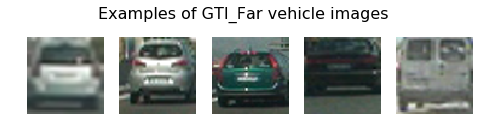

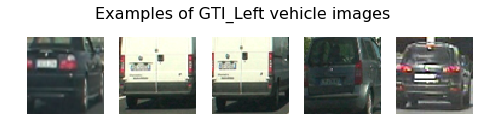

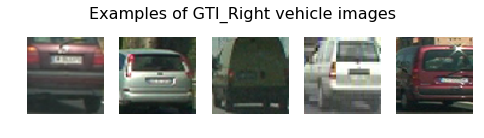

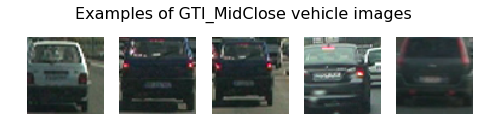

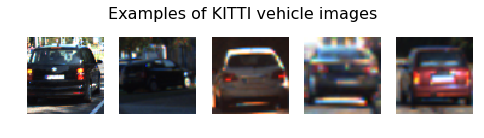

In [9]:
# plot some vehicle images
vahicle_lists = [
        vehicles_gti_far,
        vehicles_gti_left,
        vehicles_gti_right,
        vehicles_gti_mid,
        vehicles_kitti
    ]
title_list = [
        'Examples of GTI_Far vehicle images',
        'Examples of GTI_Left vehicle images',
        'Examples of GTI_Right vehicle images',
        'Examples of GTI_MidClose vehicle images',
        'Examples of KITTI vehicle images'
    ]
for i, sources in enumerate(vahicle_lists):
    plt.figure(figsize=(8,2))
    plt.suptitle(title_list[i], fontsize=16)
    for j, path in enumerate(sources[0:5]):
        img = mpimg.imread(path)
        plt.subplot(1,5,j+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()
    plt.close()

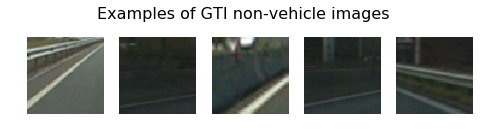

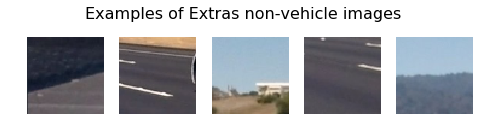

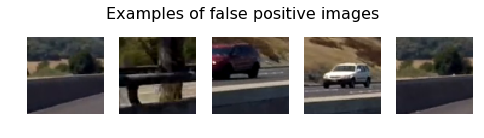

In [12]:
# plot some vehicle images
non_vahicle_lists = [
        non_vehicles_gti,
        non_vehicles_extras,
        non_vehicles_false_positives
    ]
title_list = [
        'Examples of GTI non-vehicle images',
        'Examples of Extras non-vehicle images',
        'Examples of false positive images'
    ]
for i, sources in enumerate(non_vahicle_lists):
    plt.figure(figsize=(8,2))
    plt.suptitle(title_list[i], fontsize=16)
    for j, path in enumerate(sources[90:95]):
        img = mpimg.imread(path)
        plt.subplot(1,5,j+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()
    plt.close()

### Dataset plots

Plot the number of examples from dataset sources.

In [14]:
# Numbers
print('Number of vehicles in GTI_Far: ' + str(len(vehicles_gti_far)))
print('Number of vehicles in GTI_Left: ' + str(len(vehicles_gti_left)))
print('Number of vehicles in GTI_Right: ' + str(len(vehicles_gti_right)))
print('Number of vehicles in GTI_MiddleClose: ' + str(len(vehicles_gti_mid)))
print('Number of vehicles in KITTI_extracted: ' + str(len(vehicles_kitti)))
print('Total number of vehicle examples: ' +
    str(
        len(vehicles_gti_far)
        + len(vehicles_gti_left)
        + len(vehicles_gti_right)
        + len(vehicles_gti_mid)
        + len(vehicles_kitti))
    )

print()
print('Number of non-vehicles in GTI: ' + str(len(non_vehicles_gti)))
print('Number of non-vehicles in Extras: ' + str(len(non_vehicles_extras)))
print('Total number of non-vehicle examples: '
    + str(len(non_vehicles_gti) + len(non_vehicles_extras)))

Number of vehicles in GTI_Far: 834
Number of vehicles in GTI_Left: 909
Number of vehicles in GTI_Right: 664
Number of vehicles in GTI_MiddleClose: 419
Number of vehicles in KITTI_extracted: 5966
Total number of vehicle examples: 8792

Number of non-vehicles in GTI: 3900
Number of non-vehicles in Extras: 5068
Total number of non-vehicle examples: 8968


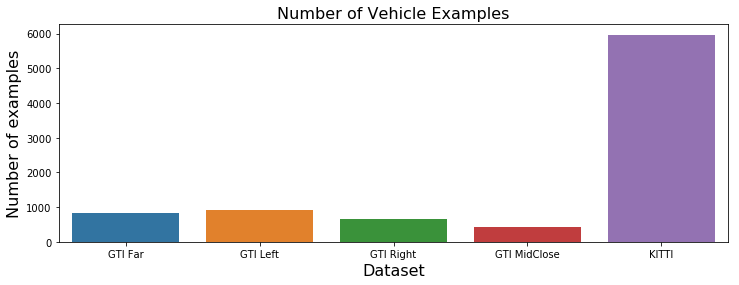

In [15]:
# plot number of vehicle examples
n_vehicles_gti_far = len(vehicles_gti_far)
n_vehicles_gti_left = len(vehicles_gti_left)
n_vehicles_gti_right = len(vehicles_gti_right)
n_vehicles_gti_mid = len(vehicles_gti_mid)
n_vehicles_kitti = len(vehicles_kitti)

vehicle_dataset_numbers = [
        n_vehicles_gti_far,
        n_vehicles_gti_left,
        n_vehicles_gti_right,
        n_vehicles_gti_mid,
        n_vehicles_kitti
    ]

vehile_dataset_labels = [
        'GTI Far',
        'GTI Left',
        'GTI Right',
        'GTI MidClose',
        'KITTI'
    ]

n_non_vehicles_gti = len(non_vehicles_gti)
n_non_vehicles_extras = len(non_vehicles_extras)

# plot num vehicles
plt.figure(figsize=(12,4))
plt.title('Number of Vehicle Examples', fontsize=16)
plt.ylabel('Number of examples', fontsize=16)
plt.xlabel('Dataset', fontsize=16)
sns.barplot(x=vehile_dataset_labels, y=vehicle_dataset_numbers)
plt.show()
plt.close()

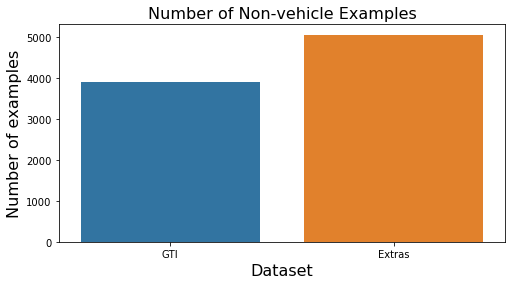

In [16]:
# plot number of vehicle examples
n_non_vehicles_gti = len(non_vehicles_gti)
n_non_vehicles_extras = len(non_vehicles_extras)

non_vehicle_dataset_numbers = [
        n_non_vehicles_gti,
        n_non_vehicles_extras
    ]
non_vehile_dataset_labels = [
        'GTI',
        'Extras'
    ]

# plot num non vehicles
plt.figure(figsize=(8,4))
plt.title('Number of Non-vehicle Examples', fontsize=16)
plt.ylabel('Number of examples', fontsize=16)
plt.xlabel('Dataset', fontsize=16)
sns.barplot(x=non_vehile_dataset_labels, y=non_vehicle_dataset_numbers)
plt.show()
plt.close()

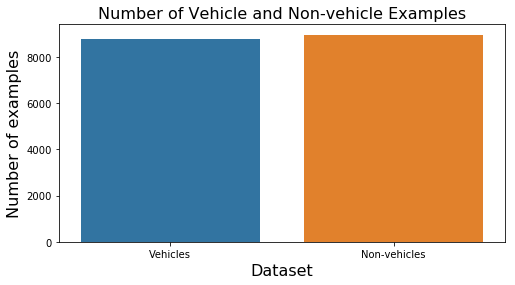

In [17]:
# plot vehicles and non-vehicles
n_vehicles = (
        n_vehicles_gti_far
        +n_vehicles_gti_left
        +n_vehicles_gti_right
        +n_vehicles_gti_mid
        +n_vehicles_kitti
    )
n_non_vehicles = n_non_vehicles_gti + n_non_vehicles_extras

n_list = [n_vehicles, n_non_vehicles]
n_labels = ['Vehicles', 'Non-vehicles']

plt.figure(figsize=(8,4))
plt.title('Number of Vehicle and Non-vehicle Examples', fontsize=16)
plt.ylabel('Number of examples', fontsize=16)
plt.xlabel('Dataset', fontsize=16)
sns.barplot(x=n_labels, y=n_list)
plt.show()
plt.close()

---

For the training processes, please go on to [this notebook](./train-model-with-best-dataset.ipynb) for best model training or go on to [this notebook](./train-model-with-augmented-best-dataset.ipynb) for augmented training with false positives.

---